# Fuzzy C-Means: Local Minimum May Not Be the Global One

by [Marek Gagolewski](https://www.gagolewski.com)

This notebook is a simple illustration
that a solution identified by the FCM does not necessarily correspond
to the global minium of the underlying objective function.
Even multiple restarts from different random initial guesses may not
be enough, although they can improve the solution significantly.
This is a well known behaviour that we also observe in the case
of the classic k-means method (compare, e.g., the `nstart`
argument to the `kmeans()` function in R or the
`n_init` parameter in Python's `sklearn.cluster.KMeans`).

## `Unbalance` Data Set from the SIPU Benchmark Battery

Data set source: M. Rezaei, P. Fränti, Set-matching methods for external cluster
validity, IEEE Trans. on Knowledge and Data Engineering, 28(8), pp. 2173-2186, 2016.

Web: https://cs.joensuu.fi/sipu/datasets/
        
See also: `sipu/unbalance` in https://github.com/gagolews/clustering_benchmarks_v1

In [1]:
%load_ext Cython

In [2]:
import numpy as np
import pandas as pd
import genieclust
import matplotlib.pyplot as plt

X = (np.loadtxt("unbalance.data.gz", ndmin=2))
X = (X-X.mean(axis=0))/X.std(axis=0) # standardise the variables
y = np.loadtxt("unbalance.labels0.gz", dtype="int")-1
c = len(np.bincount(y))

The data set consists of $n=6500$ points in $\mathbb{R}^2$ and the true label vector defines $c=8$ reference clusters:

In [3]:
X.shape[0], c

(6500, 8)

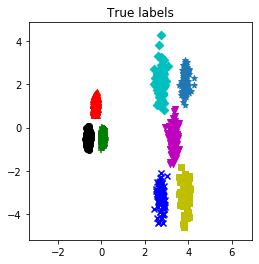

In [4]:
plt.rcParams["figure.figsize"] = (4, 4) 
genieclust.plots.plot_scatter(X, labels=y)
plt.title("True labels")
plt.axis("equal")
plt.show()

Here are the true label counts; note that this data set is highly imbalanced in terms of the cluster sizes.

In [5]:
np.bincount(y) 

array([2000, 2000, 2000,  100,  100,  100,  100,  100])

Cluster centroids:

In [6]:
V_true = np.array(pd.concat([pd.DataFrame(X), pd.Series(y).rename("y")], axis=1).groupby(y).mean().iloc[:, :-1])
V_true

array([[-0.61949876, -0.47684209],
       [-0.27474286,  1.08468173],
       [ 0.07053131, -0.48418474],
       [ 2.72750711, -3.18279995],
       [ 2.72037076,  2.13569085],
       [ 3.3063359 , -0.49279701],
       [ 3.86284921, -3.11128099],
       [ 3.8571432 ,  2.17808903]])

## An Implementation of the Fuzzy C-means Method in Cython

J. Bezdek, R. Ehrlich, W. Full, FCM: The fuzzy c-means clustering algorithm,
Computers & Geosciences 10 (1984) 191-203. doi:10.1016/0098-3004(84)90020-7

This is a straightforward implementation for educational purposes.
It has not been optimised for speed.
However, the fact that it is written in Cython makes it run much faster than its pure Python counterpart.

In [7]:
%%cython

# ############################################################################ #
#                                                                              #
#   Copyleft (C) 2020, Marek Gagolewski <https://www.gagolewski.com>           #
#                                                                              #
#                                                                              #
#   This program is free software: you can redistribute it and/or modify       #
#   it under the terms of the GNU Affero General Public License                #
#   Version 3, 19 November 2007, published by the Free Software Foundation.    #
#   This program is distributed in the hope that it will be useful,            #
#   but WITHOUT ANY WARRANTY; without even the implied warranty of             #
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the               #
#   GNU Affero General Public License Version 3 for more details.              #
#   You should have received a copy of the License along with this program.    #
#   If this is not the case, refer to <https://www.gnu.org/licenses/>.         #
#                                                                              #
# ############################################################################ #

"""
Implements the Fuzzy c-means method.

This is a straightforward implementation for educational purposes.
It has not been optimised for speed.


References
----------

J. Bezdek, R. Ehrlich, W. Full, FCM: The fuzzy c-means clustering algorithm,
Computers & Geosciences 10 (1984) 191-203. doi:10.1016/0098-3004(84)90020-7
"""

import scipy.spatial.distance
import numpy as np
cimport numpy as np

cdef get_V(np.ndarray[np.double_t,ndim=2] X, np.ndarray[np.double_t,ndim=2] U, float m):
    """An auxiliary subroutine that computes the cluster centres
       based on Eq. (11a) in Bezdek's paper"""
    cdef int c = U.shape[0]
    cdef int d = X.shape[1]
    cdef int i
    
    cdef np.ndarray[np.double_t,ndim=2] V = np.empty((c, d))
    for i in range(c):
        # weighted componentwise arithmetic means:
        V[i,:]  = np.sum(((U[i,:]**m).reshape(-1,1))*X, axis=0)
        V[i,:] /= np.sum(U[i,:]**m)
    return V


cpdef fcm_objective(np.ndarray[np.double_t,ndim=2] X, np.ndarray[np.double_t,ndim=2] V, np.ndarray[np.double_t,ndim=2] U, float m=2.0):
    return np.sum(U**m * scipy.spatial.distance.cdist(V, X)**2.0)


cpdef fcm(np.ndarray[np.double_t,ndim=2] X, int c, float m=2.0, V_init=None, 
    float eps=1e-8, float eps2=1e-12, int maxiter=1000, random_state=None):
    """
    Implements the Fuzzy c-means method.
    
    This is a straightforward implementation for educational purposes.
    It has not been optimised for speed.


    References
    ----------

    J. Bezdek, R. Ehrlich, W. Full, FCM: The fuzzy c-means clustering algorithm,
    Computers & Geosciences 10 (1984) 191-203. doi:10.1016/0098-3004(84)90020-7


    Details
    -------

    By default, the method starts from a pseudo-random initial guess.
    However, a user may provide a set of initial cluster centres (V_init).

    The algorithms' convergence criteria are controlled with
    the eps and maxiter parameters.

    The division by zero error mentioned in this letter is avoided
    by assuming 0/1=1. Moreover, we are checking here whether a current
    intermediate V is amongst the V_prev_history_size previous ones.


    Returns
    -------

    V, U, converged:
        cluster centroids and membership degrees;
        converged=False if maxiter was reached
    """
    cdef int n, d, it, j, i
    cdef np.ndarray[np.double_t,ndim=2] V, V_prev, U
    cdef np.ndarray[np.double_t,ndim=2] D
    cdef np.ndarray[np.int_t] which_zero
    n = X.shape[0]
    d = X.shape[1]
    
    np.random.seed(random_state)
    if V_init is None: # the default -- random guess
        # start with a random "fuzzy" partition:
        U = np.random.rand(c, n)
        U = U/np.sum(U, axis=0).reshape(1,-1)
        V = get_V(X, U, m)
    else:
        # U will be determined in the first iteration below:
        U = np.empty((c, n))
        V = V_init

    it = 1
    while True:
        # D[i,j] gives the Euclidean distance between V[i,:] and X[j,:]:
        D = scipy.spatial.distance.cdist(V, X)

        for j in range(n):
            which_zero = (D[:,j] < eps2).astype("int")
            if np.any(which_zero):
                # EXTRA: avoid division by 0
                U[:,j] = which_zero*np.sum(which_zero)
            else:
                for i in range(c):
                    U[i,j] = np.sum((D[i,j]/D[:,j])**(2.0/(m-1.0)))

        U = U**(-1.0)  # Fuzzy c-means

        V_prev = V
        V = get_V(X, U, m)

        it += 1
        if np.max(np.sum((V_prev-V)**2.0, axis=1)) <= eps or it > maxiter:
            return V, U, it <= maxiter

## Running the FCM on `unbalance`

First we start from randomly chosen initial centroids.

In [8]:
V_random, U_random, converged = fcm(X, c, maxiter=100, random_state=123)
assert converged

In [9]:
V_random

array([[ 0.07577178, -0.52542922],
       [ 0.07708487, -0.38783126],
       [ 0.08375418, -0.2332952 ],
       [-0.61796844, -0.47765988],
       [ 3.3403455 , -3.06397842],
       [ 0.07377058, -0.68411631],
       [ 3.37962477,  2.08836256],
       [-0.27261789,  1.09210347]])

Then, let's also start the FCM from the true cluster centres (this most likely yields the global minimum of the objective function, $J_2$, but we cannot be sure):

In [10]:
np.random.seed(123)
V_fromtrue, U_fromtrue, converged = fcm(X, c, V_init=V_true, maxiter=100)
assert converged

In [11]:
V_fromtrue

array([[-0.61655645, -0.4777737 ],
       [-0.27443407,  1.0875207 ],
       [ 0.06762636, -0.48502405],
       [ 2.75024328, -3.1719507 ],
       [ 2.73557924,  2.09841056],
       [ 3.30426797, -0.48281074],
       [ 3.8402362 , -3.09855456],
       [ 3.82770815,  2.22394639]])

Of course, in practice we have no access to the true cluster labels. This is only an illustration.

## Visualisation

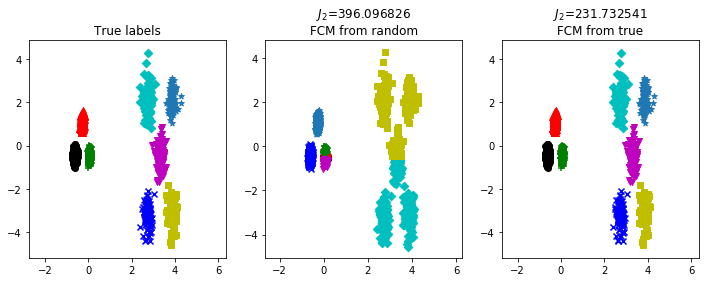

In [12]:
plt.rcParams["figure.figsize"] = (12, 4) 

plt.subplot(131)
genieclust.plots.plot_scatter(X, labels=y)
plt.title("True labels")
plt.axis("equal")

plt.subplot(132)
genieclust.plots.plot_scatter(X, labels=U_random.argmax(axis=0))
plt.title("$J_2$=%f\nFCM from random" % fcm_objective(X, V_random, U_random))
plt.axis("equal")

plt.subplot(133)
genieclust.plots.plot_scatter(X, labels=U_fromtrue.argmax(axis=0))
plt.title("$J_2$=%f\nFCM from true" % fcm_objective(X, V_fromtrue, U_fromtrue))
plt.axis("equal")

plt.show()

We see that the solution in the middle is rather sub-optimal.

## Multiple Restarts

The objective function in the FCM problem is given by (here we use the fuzzifier $m=2$):

$$
  J_m(U; v_1,\dots,v_c) = \sum_{j=1}^n \sum_{i=1}^c {u_{ij}^m} \| X_j - v_i \|^2,
$$
  
To recall, the FCM algorithm is just a heuristic that aims to numerically identify the minimum of $J_m$.
  
The value of the objective function at the global minimum is definitely not greater than:

In [13]:
fcm_objective(X, V_fromtrue, U_fromtrue)

231.7325412330409

Here are the values of the objective function at different local minima identified (starting from 10 different pseudo-random initial guesses):

In [14]:
best_obj = np.inf
for i in range(10):
    V_random, U_random, converged = fcm(X, c, maxiter=100, random_state=i+1)
    assert converged
    obj = fcm_objective(X, V_random, U_random)
    print(obj)
    if obj < best_obj:
        best_obj = obj
        V_best = V_random
        U_best = U_random

340.4767726302996
374.37429534583697
374.3742848081917
249.32568919580243
381.44480876278124
274.66707244984786
396.09683158011603
251.83935438874835
251.83935479448027
362.2881508546466


Hence, even restarting the method 10 times does not guarantee finding the global minimum. However, it can improve the solution significantly.

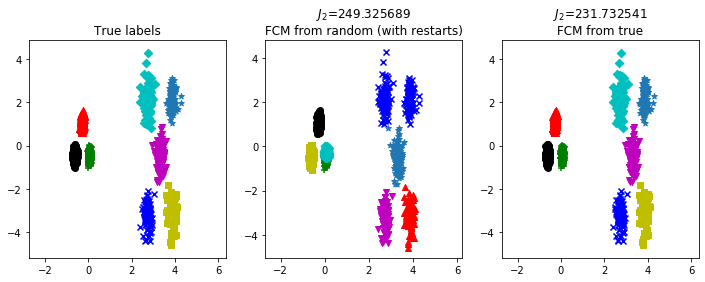

In [15]:
plt.rcParams["figure.figsize"] = (12, 4) 

plt.subplot(131)
genieclust.plots.plot_scatter(X, labels=y)
plt.title("True labels")
plt.axis("equal")

plt.subplot(132)
genieclust.plots.plot_scatter(X, labels=U_best.argmax(axis=0))
plt.title("$J_2$=%f\nFCM from random (with restarts)" % fcm_objective(X, V_best, U_best))
plt.axis("equal")

plt.subplot(133)
genieclust.plots.plot_scatter(X, labels=U_fromtrue.argmax(axis=0))
plt.title("$J_2$=%f\nFCM from true" % fcm_objective(X, V_fromtrue, U_fromtrue))
plt.axis("equal")

plt.show()

QED.